# In this notebook, we are going to implement VGG16 model to analysis the data
# Applied oversampling for the imbalance data.
## https://arxiv.org/abs/1409.1556


In [1]:
import gc

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image

# load metadata.csv

In [2]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

# preprocess labels

In [3]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
8184  HAM_0005840  ISIC_0032260   nv      histo  45.0  female   
2627  HAM_0002559  ISIC_0034047  bcc      histo  70.0    male   
4626  HAM_0001060  ISIC_0024405   nv  follow_up  45.0    male   
6950  HAM_0001975  ISIC_0028488   nv      histo  30.0  female   
4029  HAM_0002728  ISIC_0026570   nv  follow_up  70.0  female   

         localization  label  
8184            chest      5  
2627             face      1  
4626             foot      5  
6950  upper extremity      5  
4029  lower extremity      5  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [4]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df",
                 4:"mel",5:"nv",6:"vasc"}

# Preprocess image

In [5]:
from glob import glob
image_size = 150 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [6]:
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

# Print some image

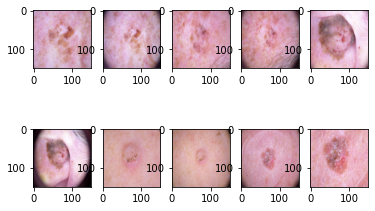

In [7]:
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1


# Image to array

In [8]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list()).astype("short")
label_to_one_hot = to_categorical(df['label'], num_classes=7)


# Split train, test data

In [9]:
#80% data for training
#20% data for testing
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.2,random_state=87,stratify=label_to_one_hot)

#80% train data for training
#20% train data for validation
train_data,valid_data,train_label,valid_label = train_test_split(train_data,train_label,test_size=0.2,random_state=87,stratify=train_label)

# Apply over sampling

In [10]:
#from imblearn.over_sampling import SMOTE
#over_sample = SMOTE(random_state=87)
#train_data = train_data.reshape(-1,image_size*image_size*3)
#train_data_oversample, train_label_oversample = over_sample.fit_resample(train_data, train_label)
#train_data_oversample = train_data_oversample.reshape(-1,image_size,image_size,3)

# Generate more Image for training
# center and normalize the image

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(rescale=1.0/255., featurewise_center=True,
    rotation_range=50 ,horizontal_flip=True,vertical_flip=True,
    height_shift_range=0.2,width_shift_range=0.2, shear_range=0.2)
data_gen.fit(train_data)

valid_data_gen = ImageDataGenerator(rescale=1.0/255., featurewise_center=True,
    rotation_range=50 ,horizontal_flip=True,vertical_flip=True,
    height_shift_range=0.2,width_shift_range=0.2, shear_range=0.2)
valid_data_gen.fit(valid_data)

test_data = test_data/255.0

# setup VGG-16 model
# reference: https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Dropout,Flatten,BatchNormalization
num_classes = 7

vgg16_model = VGG16(input_shape=(image_size,image_size,3), include_top = False, weights='imagenet')

# don't use the pre-trained layers
for layer in vgg16_model.layers:
    layer.trainable = False

#Flatten layer
temp_layer = BatchNormalization()(vgg16_model.output)
temp_layer = Flatten()(temp_layer)
temp_layer = Dropout(0.3)(temp_layer)

#Dense layer 1
temp_layer = Dense(2048,activation='relu')(temp_layer)

#Dense layer 2
temp_layer = Dense(2048,activation='relu')(temp_layer)

#output layer
temp_layer = Dense(7,activation='softmax')(temp_layer)

model = Model(vgg16_model.input,temp_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Use Adam optimizer with 0.001 weights decay

In [13]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

C:\Users\andre\anaconda3\envs\cmpt340_conda\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# ModelCheckpoint: save the best result
# EarlyStopping: stop early if there is no change in "val_acc" after 150 runs

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
check_point = ModelCheckpoint("model/VGG_16.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=150, verbose=1, mode='auto')

# Train

In [ ]:
try:
    model.load_weights('model/VGG_16_weight.h5')
except:
    print("new model")
epochs = 2000

train_history = model.fit(
    data_gen.flow(train_data,train_label,batch_size=128),
    validation_data=valid_data_gen.flow(valid_data,valid_label,batch_size=32),
    epochs=epochs,
    steps_per_epoch=len(train_data)/128,
    verbose=2,callbacks=[check_point,early_stop])

model.save_weights('model/VGG_16_weight.h5')

Epoch 1/2000
50/50 - 31s - loss: 0.8021 - acc: 0.7254 - val_loss: 0.9698 - val_acc: 0.7012

Epoch 00001: val_acc improved from -inf to 0.70119, saving model to model\VGG_16.h5
Epoch 2/2000
50/50 - 22s - loss: 0.7690 - acc: 0.7310 - val_loss: 0.8617 - val_acc: 0.7068

Epoch 00002: val_acc improved from 0.70119 to 0.70680, saving model to model\VGG_16.h5
Epoch 3/2000
50/50 - 21s - loss: 0.7575 - acc: 0.7332 - val_loss: 0.8290 - val_acc: 0.7112

Epoch 00003: val_acc improved from 0.70680 to 0.71117, saving model to model\VGG_16.h5
Epoch 4/2000
50/50 - 21s - loss: 0.7329 - acc: 0.7422 - val_loss: 0.7735 - val_acc: 0.7137

Epoch 00004: val_acc improved from 0.71117 to 0.71366, saving model to model\VGG_16.h5
Epoch 5/2000
50/50 - 22s - loss: 0.7269 - acc: 0.7444 - val_loss: 0.7754 - val_acc: 0.7143

Epoch 00005: val_acc improved from 0.71366 to 0.71429, saving model to model\VGG_16.h5
Epoch 6/2000
50/50 - 21s - loss: 0.7035 - acc: 0.7405 - val_loss: 0.7587 - val_acc: 0.7293

Epoch 00006: val

In [ ]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

# train history

In [ ]:
plot_train_history(train_history,'acc','val_acc')


# loss

In [ ]:
plot_train_history(train_history,'loss','val_loss')


# Score

In [ ]:
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])


# Confusion Matrix

In [ ]:
prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
prediction_label = np.argmax(test_label,axis=1)

mapping = lambda x:features_dict[x]
pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
pred_label_to_feature = np.array([mapping(x) for x in prediction_label])

print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,rownames=['actual'],colnames=['predicted']))

# inceptionV3 model to analysis the data
# Applied oversampling for the imbalance data.
## https://arxiv.org/abs/1409.1556

# Setup InceptionV3 Model
# reference: https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,BatchNormalization
num_classes = 7
dimension = image_size*image_size*3

InceptionV3_model = InceptionV3(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet')

# don't use the pre-trained model
for layer in InceptionV3_model.layers:
    layer.trainable = False

#Flatten layer
temp_layer = BatchNormalization()(InceptionV3_model.output)
temp_layer = Flatten()(temp_layer)
temp_layer = Dropout(0.3)(temp_layer)

#Dense layer 1
temp_layer = Dense(1024,activation='relu')(temp_layer)

#Dense layer 2
temp_layer = Dense(1024,activation='relu')(temp_layer)

#output layer
temp_layer = Dense(7,activation='softmax')(temp_layer)

model = Model(InceptionV3_model.input,temp_layer)
#model.summary()

# Use Adam optimizer

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])


# ModelCheckpoint: save the best result
# EarlyStopping: stop early if there is no change in "val_acc" after 150 runs

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
check_point = ModelCheckpoint("model/InceptionV3.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=150, verbose=1, mode='auto')

# Train

In [ ]:
try:
    model.load_weights('model/InceptionV3_weight.h5')
except:
    print("new model")

epochs = 2000

train_history = model.fit(
    data_gen.flow(train_data,train_label,batch_size=128),
    validation_data=valid_data_gen.flow(train_data,train_label,batch_size=32),
    epochs=epochs,
    steps_per_epoch=len(train_data)/128,
    verbose=2,callbacks=[check_point,early_stop])

model.save_weights('model/InceptionV3_weight.h5')

# train history

In [ ]:
plot_train_history(train_history,'acc','val_acc')

# loss

In [ ]:
plot_train_history(train_history,'loss','val_loss')

# Score

In [ ]:
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

# Confusion Matrix

In [ ]:
prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
prediction_label = np.argmax(test_label,axis=1)

mapping = lambda x:features_dict[x]
pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
pred_label_to_feature = np.array([mapping(x) for x in prediction_label])

print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,rownames=['actual'],colnames=['predicted']))

# Efficient model to analysis the data
## https://arxiv.org/abs/1409.1556

# Setup Efficient Net model
# reference: https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,BatchNormalization
import efficientnet.tfkeras as ef
num_classes = 7
dimension = image_size*image_size*3

EN_model = ef.EfficientNetB0(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet')
for layer in EN_model.layers:
    layer.trainable = False

#Flatten layer
temp_layer = BatchNormalization()(EN_model.output)
temp_layer = Flatten()(temp_layer)
temp_layer = Dropout(0.3)(temp_layer)

#Dense layer 1
temp_layer = Dense(1024,activation='relu')(temp_layer)

#Dense layer 2
temp_layer = Dense(1024,activation='relu')(temp_layer)

#output layer
temp_layer = Dense(7,activation='softmax')(temp_layer)

model = Model(EN_model.input,temp_layer)
#model.summary()

# Use Adam optimizer

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

# ModelCheckpoint: save the best result
# EarlyStopping: stop early if there is no change in "val_acc" after 150 runs

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
check_point = ModelCheckpoint("model/Efficient_Net.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=150, verbose=1, mode='auto')

# Train

In [ ]:
try:
    model.load_weights('model/Efficient_Net_weight.h5')
except:
    print("new model")
epochs = 2000

train_history = model.fit(
    data_gen.flow(train_data,train_label,batch_size=128),
    validation_data=valid_data_gen.flow(train_data,train_label,batch_size=32),
    epochs=epochs,
    steps_per_epoch=len(train_data)/128,
    verbose=2,callbacks=[check_point,early_stop])


model.save_weights('model/Efficient_Net_weight.h5')

# Train history

In [ ]:
plot_train_history(train_history,'acc','val_acc')

# Loss

In [ ]:
plot_train_history(train_history,'loss','val_loss')

# Score


In [ ]:
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

# confusion matrix

In [ ]:
prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
prediction_label = np.argmax(test_label,axis=1)

mapping = lambda x:features_dict[x]
pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
pred_label_to_feature = np.array([mapping(x) for x in prediction_label])

print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,rownames=['actual'],colnames=['predicted']))